In [1]:
%matplotlib inline
from utils.dataInfo import getTrainData, getTestData, plot_pixel_array, rle2mask
from utils.pneumonia_dataset import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom
from scipy.sparse import csc_matrix, save_npz, load_npz

from networks.network import Thicc_Net
from utils.pneumonia_dataset import PneumoniaDataset
from utils.trainer import train_loop

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
trainPath = 'siim/dicom-images-train/'
testPath = 'siim/dicom-images-test/'
maskPath = 'siim/mask/'

In [3]:
rles_df = pd.read_csv('siim/train-rle.csv')
rles_df.columns = ['ImageId', 'EncodedPixels']

In [4]:
train_df = getTrainData(trainPath, rles_df)

In [ ]:
test_df = getTestData(testPath)

In [1]:
# df_pos = pd.DataFrame(train_df.loc[train_df['has_pneumothorax']==True])
# df_neg = pd.DataFrame(train_df.loc[train_df['has_pneumothorax']==False])

In [2]:
# #20ish % for val 
# train_df= pd.concat([df_pos.iloc[:1904], df_neg[:6637]])
# val_df = pd.concat([df_pos.iloc[1904:], df_neg[6637:]])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
model = Thicc_Net([3,3,3,3]) 

if torch.cuda.device_count()>1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

save_bst = 'exp/exp3_512/best.pth'
state_dict = torch.load(save_bst)#path_to_experiment+saved_name)
model.load_state_dict(state_dict)

In [10]:
def image(img, lb=None, sz=10,color='gray'):
    plt.figure()
    plt.subplots(figsize=(sz,sz))
    plt.imshow(img, cmap=color)
    if lb is not None:
        plt.imshow(lb, alpha=.4, cmap='prism')
    plt.show()

In [11]:
pneumoni_dataset_val = PneumoniaDataset(test_df,
                                      dims=512,                                      
                                      train=False, 
                                      val=False,
                                      transform=False)

batch_size = 4

val_loader = torch.utils.data.DataLoader(dataset=pneumoni_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           drop_last=True)

In [12]:
171*8

1368

In [13]:
model.eval()
res = []
count =0
for images in val_loader:
    img = Variable(images.float()).to(device)
    outputs = model(img)
    
    size = outputs.shape[0]
    if size==8:
        for i in range(8):
            res.append(F.sigmoid(outputs)[i].squeeze().data.cpu().numpy()) 
    if size==4:
        for i in range(4):
            res.append(F.sigmoid(outputs)[i].squeeze().data.cpu().numpy()) 
        
    

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
len(res), res[0].shape

(100, (512, 512))

In [21]:
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [22]:
def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [25]:
best_threshold = 0.35
min_size = 3500
encoded_pixels = []
df = pd.read_csv('siim/sample_submission.csv')

In [26]:
for i in range(len(res)):
    if res[i].shape !=(1024,1024):
         probability = cv2.resize(res[i], dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        
    
    predict, num_predict = post_process(probability, best_threshold, min_size)
    if num_predict == 0:
        encoded_pixels.append('-1')
    else:
        r = run_length_encode(predict)
        encoded_pixels.append(r)
        
df['EncodedPixels'] = encoded_pixels
df.to_csv('submission.csv', columns=['ImageId', 'EncodedPixels'], index=False)

In [21]:
ii=0
im1 = pydicom.dcmread(train_df.iloc[ii]['file_path']).pixel_array
mk = load_npz('siim/mask/'+train_df.iloc[ii]['id']+'.npz').todense().astype('uint8')
mk[mk>0]=1


<Figure size 432x288 with 0 Axes>

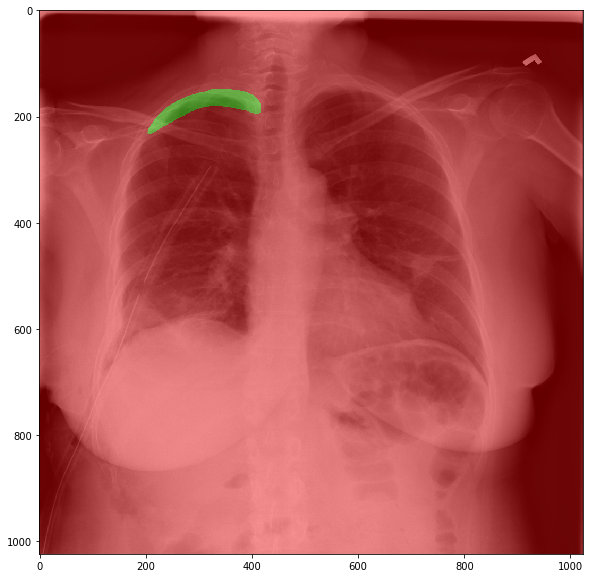

In [22]:
image(im1,mk)#,res[0][0])

In [29]:
res[0].shape

(512, 512)

In [26]:
mkk = res[0][ii]

# mkk[mkk<.5] =1

In [27]:
mkk.max(), mkk.min()

(0.0006619245, 1.5231658e-09)

In [110]:
mkk[mkk<.25]=0

In [34]:
mkk = scipy.misc.imresize(res[0],(1024,1024)).astype('uint8')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
